In [10]:
import os.path
from collections import Counter

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import seaborn

%matplotlib inline

In [11]:
SIMULATIONS = 1000 * 1000


ecs = [
    "FL", "PA", "NC", "MN", "CO",
    "OH", "WI", "VA", "MI", "NV",
    "AZ", "NJ", "NH", "IA", "GA",
    "NM", "RI", "OR", "WA", "AK",
    "SC", "DE", "IL", "TX", "CT",
    "IN", "NB2", "MO", "ME", "MA", "NY",
    "ND", "KS", "SD", "MS", "VT",
    "ME2", "UT", "MT", "TN", "LA",
    "KY", "NB1", "NB", "AR", "OK",
    "ID", "AL",
    "ME1", "WV", "CA", "MD", "WY",
    "HI", "NB3", "DC",
]

ec_votes = {
    "WA": 12,
    "OR": 7,
    "CA": 55,
    "NV": 6,
    "MT": 3,
    "ID": 4,
    "UT": 6,
    "AZ": 11,
    "CO": 9,
    "NM": 5,
    "WY": 3,
    "ND": 3,
    "SD": 3,
    "NB": 2, "NB1": 1, "NB2": 1, "NB3": 1,
    "KS": 6,
    "OK": 7,
    "TX": 38,
    "LA": 8,
    "AR": 6,
    "MO": 10,
    "IA": 6,
    "MN": 10,
    "WI": 10,
    "IL": 20,
    "MI": 16,
    "IN": 11,
    "TN": 11,
    "KY": 8,
    "MS": 6,
    "AL": 9,
    "GA": 16,
    "FL": 29,
    "HI": 4,
    "AK": 3,
    "DE": 3,
    "DC": 3,
    "VT": 3,
    "ME": 2, "ME1": 1, "ME2": 1,
    "NH": 4,
    "RI": 4,
    "WV": 5,
    "CT": 7,
    "SC": 9,
    "MD": 10,
    "MA": 11,
    "VA": 13,
    "NJ": 14,
    "NC": 15,
    "OH": 18,
    "PA": 20,
    "NY": 29,
}

# Pixels to the midpoint
fifty_percent = 206.

# Number of stdevs covered by symmetric 80%
eighty_percent = 1.2816

In [33]:
def prob_of_winning(fifty_percent, mean, stdev):
    zscore = (fifty_percent - mean) / stdev
    return st.norm.cdf(zscore)


def get_dists():
    filename = os.path.expanduser("2016 Election Forecast _ FiveThirtyEight.htm")
    with open(filename) as handle:
        data = handle.read()
    soup = BeautifulSoup(data, "lxml")

    c = {"class": "forecast"}
    rect_class = {"class": "ci D"}
    forecasts = soup.find_all("g", c)
    dists = [
        {
            "name": ec,
            "width": float(rect["width"]),
            "left": float(rect["x"]),
            # "center": float(circle["cx"])
        }
        for forecast, ec in zip(forecasts, ecs)
        for rect, circle in zip(forecast.find_all("rect", rect_class), forecast.find_all("circle"))
    ]

    # Back out the mean and stdev, precalculate linear probability
    for d in dists:
        mean = d["left"] + d["width"] / 2.
        stdev = d["width"] / (2 * eighty_percent)
        prob = prob_of_winning(fifty_percent, mean, stdev)
        d["prob"], d["mean"], d["stdev"] = prob, mean, stdev

    return dists


def simulate(dists):
    """
    Do draws from a linear distribution, counting state EC votes
    when the random variable does not exceed the probability of
    winning the state.
    """
    state_probs = np.array([d["prob"] for d in dists])
    prob_iter = (
        sum(
            ec_votes[state]
            for state, prob, state_prob in zip(ecs, np.random.random(len(dists)), state_probs)
            if state_prob > prob)
        for _ in range(SIMULATIONS)
    )
    return Counter(prob_iter)


In [34]:
dists = get_dists()
results = simulate(dists)


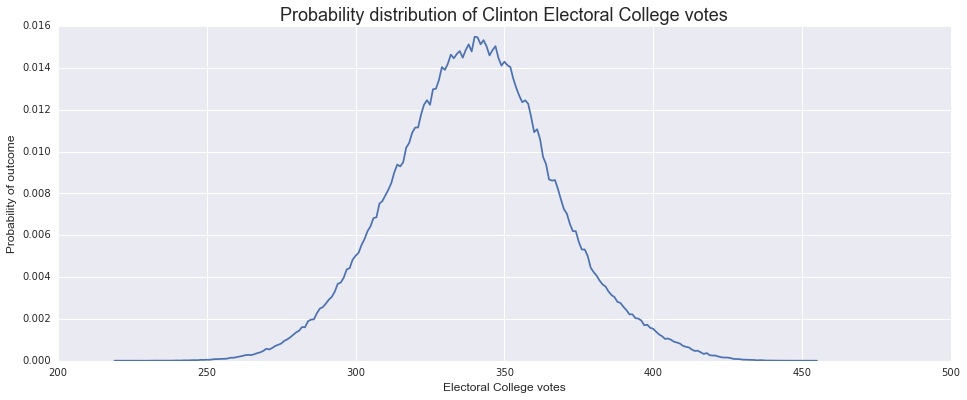

In [35]:
x = list(results.keys())
y = [v / float(SIMULATIONS) for v in results.values()]
plt.figure(figsize=(16, 6))
plt.plot(x, y)
plt.xlabel("Electoral College votes", fontsize=12)
plt.ylabel("Probability of outcome", fontsize=12)
plt.title("Probability distribution of Clinton Electoral College votes", fontsize=18)
plt.show()

In [24]:
wins = sum(v for k, v in results.items() if k >= 270)
losses = sum(v for k, v in results.items() if k <= 268)

print(float(wins) / SIMULATIONS)
print(float(losses) / SIMULATIONS)

0.99574
0.003747
